# Songs Similarities by Lyrics Analysis

Date: 5/17/2022

*Pls upvote if you found this helpful!*

**How can we find the similarity amongst songs lyrics (not context or rhyme)?** In this notebook I will do the following preprocessing and analysis to answer that question:
- 1. Scrapes the lyrics of all songs from 2010-2019.
    - Credit: [Introduction to Cultural Analytics & Pythons](https://melaniewalsh.github.io/Intro-Cultural-Analytics/04-Data-Collection/08-Collect-Genius-Lyrics.html).
- 2. Preprocessing songs' lyrics with some core concepts:
    - [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model).
    - [Vector Space Model](https://en.wikipedia.org/wiki/Vector_space_model#:~:text=Vector%20space%20model%20or%20term,retrieval%2C%20indexing%20and%20relevancy%20rankings.).
    - Term Frequency - Inverse Document Frequency ([TF-IDF](https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/)).
- 3. Lyrics comparison with [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

These preprocessing steps maybe helpful for your to do song prediction or generation. Feel free to leave comments, make a copy of my notebook, and improve/edit it!

**Note:** Due to the size of the database (1000 songs), the notebook will take a bit of time to run.

# Working with LyricsGenius and Genius Songs Database

### About Genius.com:
- [Link to Genius API](https://docs.genius.com/#/getting-started-h1).
- Genius in a nutshell: "Genius is the world's biggest collection of song lyrics and musical knowledge." - by [Genius](https://genius.com/). Genius provides an API for user to download songs' information including lyrics, authors info, album,...
- **How to use it?**
    - Go to the [link](https://genius.com/api-clients) to sign up with your email. You will then the **Authorization Code** in [here](https://docs.genius.com/#/getting-started-h1). Copy your Authorization Code, you will need it for **client_access_token** in the next few lines. Each account has distinct Authorization Code.
   
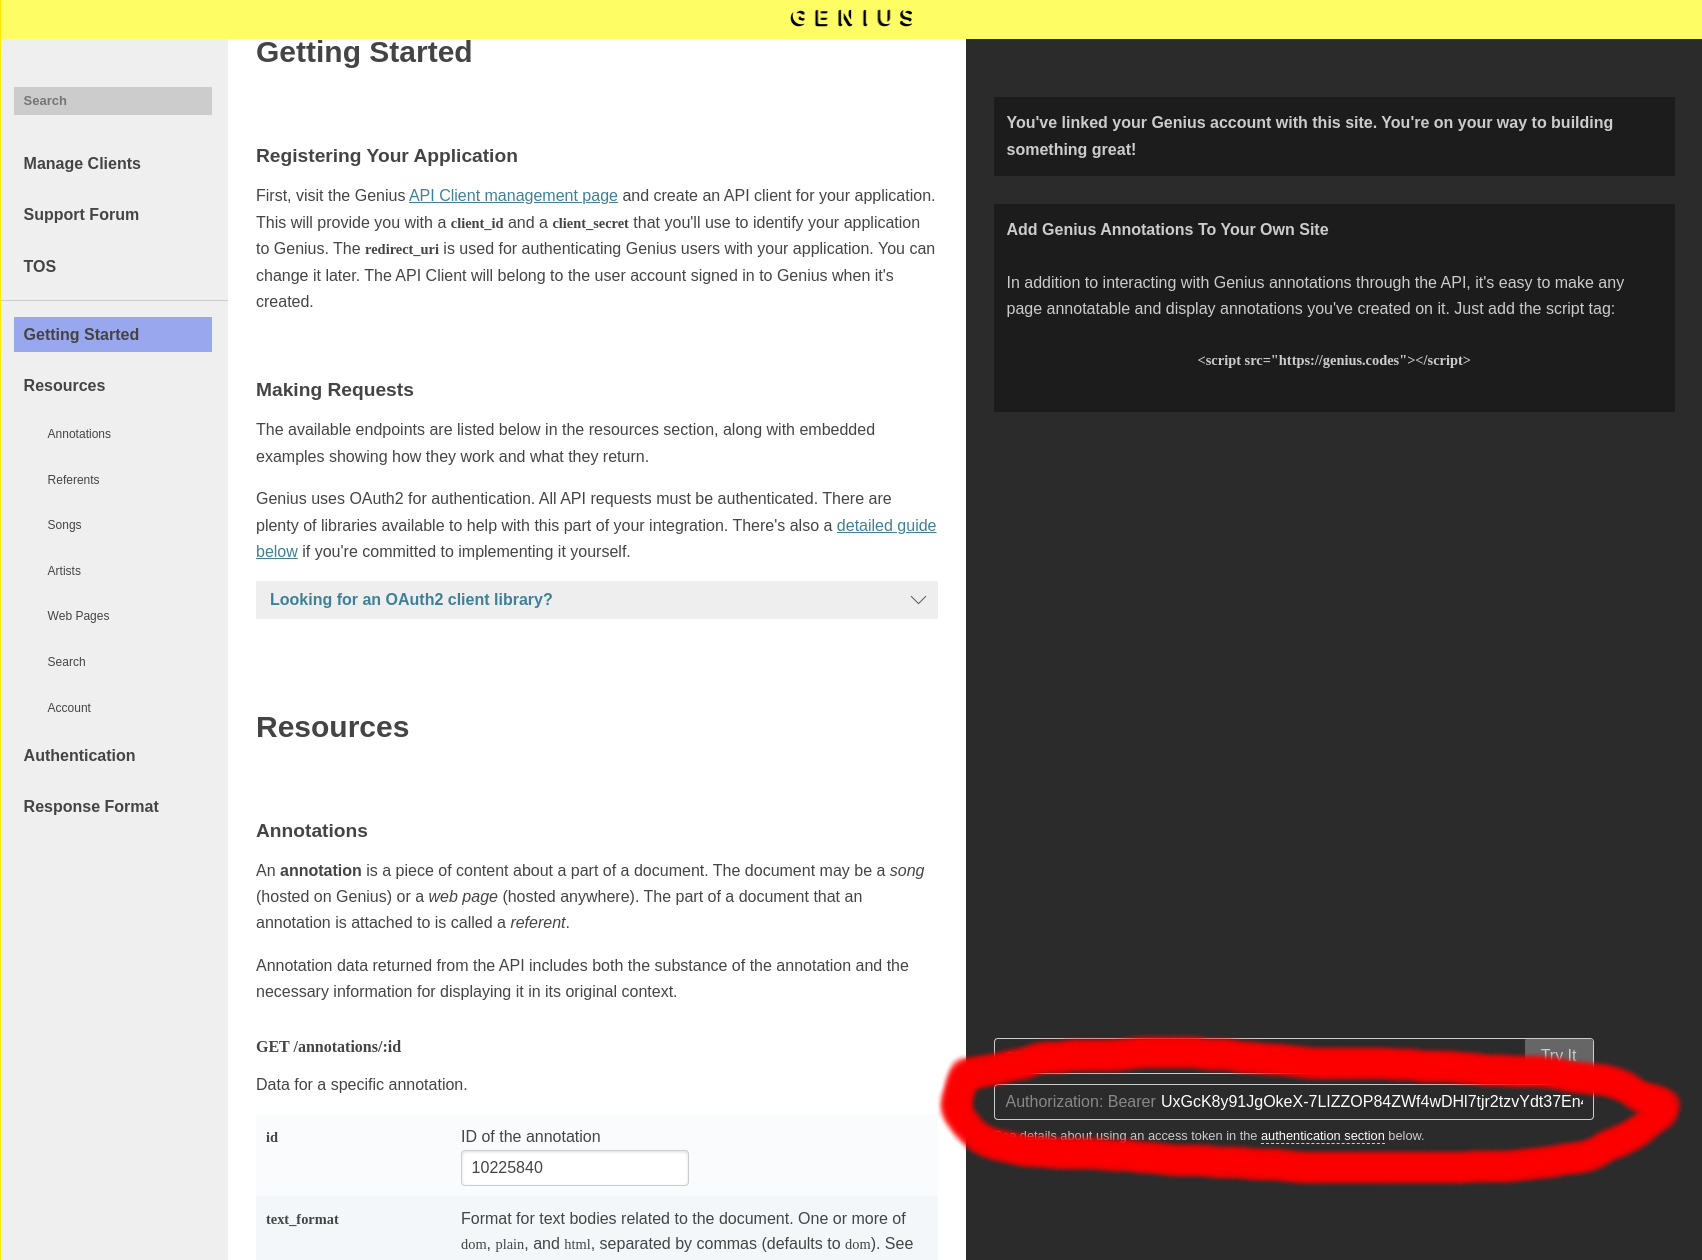

### About LyricGenius Python Package:
- [Link to Github](https://github.com/johnwmillr/LyricsGenius). In short, lyricsgenius provides a simple interface to the song, artist, and lyrics data stored on Genius.com.
- [Tutorial by Introduction to Cultural Analytics & Pythons](https://melaniewalsh.github.io/Intro-Cultural-Analytics/04-Data-Collection/08-Collect-Genius-Lyrics.html).


In [1]:
# Package for lyrics scraping
!pip install git+https://github.com/johnwmillr/LyricsGenius.git

  Cloning https://github.com/johnwmillr/LyricsGenius.git to /tmp/pip-req-build-vbkymq4f
  Running command git clone --filter=blob:none --quiet https://github.com/johnwmillr/LyricsGenius.git /tmp/pip-req-build-vbkymq4f
  Resolved https://github.com/johnwmillr/LyricsGenius.git to commit fa9528551043cd60376b900a0adacf239a93fae5
  Preparing metadata (setup.py) ... - done
  Created wheel for lyricsgenius: filename=lyricsgenius-3.0.1-py3-none-any.whl size=44687 sha256=8cf066733231b501626208a7af9ee62e51f7ce7c248e94f923de92b26d8b91d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-9pfq70yg/wheels/12/d5/2b/6b771ebb067bceb8816ec5eef0dd0d36bf069b18f03ac8ca20
Successfully built lyricsgenius


In [2]:
# Import necessary packages
import os 
import lyricsgenius
import pandas as pd
import numpy as np

In [3]:
# Log into Genius API with your Authorization Code
client_access_token='UxGcK8y91JgOkeX-7LIZZOP84ZWf4wDHl7tjr2tzvYdt37En4bgLswIjkXrz7Sw_'
LyricsGenius = lyricsgenius.Genius(client_access_token)

# The package got some timeout issue so these two lines are needed. If you don't then there will be error when you scrape
# Source: https://github.com/johnwmillr/LyricsGenius/issues/121
LyricsGenius.timeout = 15  #timeout
LyricsGenius.sleep = 5

# 1. Scrape Lyrics

To begin, we will import the original provided dataset, however, we only want the "title" column. From each title, we will get the lyric from Genius via LyricsGenius package and do some text preprocessing to it!

In [4]:
# Import original dataset.
raw_df = pd.read_csv("../input/spotify-top-100-songs-of-20152019/Spotify 2010 - 2019 Top 100.csv")

# Due to the amount of space in Free Kaggle version, I will use only half of dataset in this notebook
raw_df = raw_df[:500]
raw_df.head()

,title,artist,top genre,year released,added,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top year,artist type
0,STARSTRUKK (feat. Katy Perry),3OH!3,dance pop,2009.0,2022‑02‑17,140.0,81.0,61.0,-6.0,23.0,23.0,203.0,0.0,6.0,70.0,2010.0,Duo
1,My First Kiss (feat. Ke$ha),3OH!3,dance pop,2010.0,2022‑02‑17,138.0,89.0,68.0,-4.0,36.0,83.0,192.0,1.0,8.0,68.0,2010.0,Duo
2,I Need A Dollar,Aloe Blacc,pop soul,2010.0,2022‑02‑17,95.0,48.0,84.0,-7.0,9.0,96.0,243.0,20.0,3.0,72.0,2010.0,Solo
3,Airplanes (feat. Hayley Williams of Paramore),B.o.B,atl hip hop,2010.0,2022‑02‑17,93.0,87.0,66.0,-4.0,4.0,38.0,180.0,11.0,12.0,80.0,2010.0,Solo
4,Nothin' on You (feat. Bruno Mars),B.o.B,atl hip hop,2010.0,2022‑02‑17,104.0,85.0,69.0,-6.0,9.0,74.0,268.0,39.0,5.0,79.0,2010.0,Solo


In [5]:
# Create a new df with just songs' titles
lyrics_df = raw_df.title
lyrics_df = pd.DataFrame(lyrics_df)
lyrics_df.head()

,title
0,STARSTRUKK (feat. Katy Perry)
1,My First Kiss (feat. Ke$ha)
2,I Need A Dollar
3,Airplanes (feat. Hayley Williams of Paramore)
4,Nothin' on You (feat. Bruno Mars)


### Quick Test!
Let's test with a song title and see if LyricsGenius package works well or not.

In [6]:
# Get the first song
sample_song = lyrics_df.title[0]
print(f"Name of the first song in the database is: {sample_song}")

# Search for the song's lyric
searched_song = LyricsGenius.search_song(sample_song)
print(f"The lyric is:\n{searched_song.lyrics}")

Name of the first song in the database is: STARSTRUKK (feat. Katy Perry)
Searching for "STARSTRUKK (feat. Katy Perry)"...
Done.
The lyric is:
Starstrukk (Remix) Lyrics[Verse 1: 3OH!3]
Nice legs, Daisy Dukes makes a man go
That’s the way they all come through like
Low cut, see-through shirts that make ya
That’s the way she come through like

[Pre-Chorus: 3OH!3 & Katy Perry]
‘Cause I just set them up, just set them up
Just set them up to knock them down
‘Cause I just set them up, just set them up
Just set them up to knock them down
[Chorus: 3OH!3 & Katy Perry]
I think I should know
How
To make love to something innocent
Without leaving my fingerprints out
Now
L-O-V-E’s just another word I never learned to pronounce
How
Do I say I’m sorry?
‘Cause the word is never gonna come out
Now
L-O-V-E’s just another word I never learned to pronounce

[Verse 2: 3OH!3]
Tight jeans, double Ds makin’ me go
All the people on the street know
Iced out, lit up, make the kids go
All the people on the street 

Hmmmm, let's compare via the [link](https://genius.com/3oh-3-starstrukk-remix-lyrics). Works like a champ, they are similar! Let's scrape all songs' lyrics via for loop.

In [7]:
# Create an array to store each song's lyric
lyrics_arr = []

# Traverse through the database, get the song's lyrics from title, and do some preprocessing
for i in range(len(lyrics_df)):
    # get title
    song_title = lyrics_df.title[i]
    
    # search for song in genius.com
    searched_song = LyricsGenius.search_song(song_title)
    
    # if we can't find a song's lyrics then skip and append empty string
    if searched_song is None:
        lyrics_arr.append("")
        continue
        
    # get the lyric
    lyric = searched_song.lyrics
    
    # replace the lyrics newline with ". "
    lyric = lyric.replace("\n", ". ")
    
    # remove initial non-lyrics character:
    # Source: https://thispointer.com/remove-string-before-a-specific-character-in-python/
    # lyric = lyric[lyric.index('.') + 1 :]
    
    # append the processed lyric to the array
    lyrics_arr.append(lyric)

Searching for "STARSTRUKK (feat. Katy Perry)"...
Done.
Searching for "My First Kiss (feat. Ke$ha)"...
Done.
Searching for "I Need A Dollar"...
Done.
Searching for "Airplanes (feat. Hayley Williams of Paramore)"...
Done.
Searching for "Nothin' on You (feat. Bruno Mars)"...
Done.
Searching for "Magic (feat. Rivers Cuomo)"...
Done.
Searching for "The Time (Dirty Bit)"...
Done.
Searching for "Imma Be"...
Done.
Searching for "Talking to the Moon"...
Done.
Searching for "Just the Way You Are"...
Done.
Searching for "Teach Me How to Dougie"...
Done.
Searching for "Forget You"...
Done.
Searching for "Deuces (feat. Tyga & Kevin McCall)"...
Done.
Searching for "Memories (feat. Kid Cudi)"...
Done.
Searching for "Gettin' Over You (feat. Fergie & LMFAO)"...
Done.
Searching for "All I Do Is Win (feat. T-Pain, Ludacris, Snoop Dogg & Rick Ross)"...
Done.
Searching for "Over"...
Done.
Searching for "Find Your Love"...
Done.
Searching for "Barbra Streisand (Radio Edit)"...
Done.
Searching for "Stereo Lo

In [8]:
# Check length
len(lyrics_arr)

500

In [9]:
# Append lyric columns
lyrics_df['lyrics'] = lyrics_arr

# Replace "" with Nan
lyrics_df = lyrics_df.replace('', np.nan)

# Drop Nan
lyrics_df = lyrics_df.dropna(subset = ["lyrics"])

lyrics_df

,title,lyrics
0,STARSTRUKK (feat. Katy Perry),Starstrukk (Remix) Lyrics[Verse 1: 3OH!3]. Nic...
1,My First Kiss (feat. Ke$ha),Artist Archive: Kesha Lyrics2017 - Present: Ra...
2,I Need A Dollar,I Need a Dollar Lyrics[Chorus]. I need a dolla...
3,Airplanes (feat. Hayley Williams of Paramore),Airplanes Lyrics[Intro: Hayley Williams]. Can ...
4,Nothin' on You (feat. Bruno Mars),B.o.B Presents: The Adventures Of Bobby Ray Re...
...,...,...
495,Talking Body,Talking Body Lyrics[Intro]. Hey. Hey. . [Verse...
496,Na Na,"Rap God Lyrics[Intro]. ""Look, I was gonna go e..."
497,Riptide,Riptide Lyrics[Verse 1]. I was scared of denti...
498,Stay The Night - Featuring Hayley Williams Of ...,Stay the Night Lyrics[Produced by Zedd]. . [Ve...


In [10]:
# Check length
len(lyrics_df)

495

# 2. Preprocessing Steps

## 2.1 [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model)
- Document = Bag of words (unordered list).
- Vocabulary = Set of unique words in the bag.

### 2.1.1. Parse and Clean words: Additional Preprocessing Steps
- Replace punctuation with white space.
- Case sensitivity.

In [11]:
# Create a bag-of-words column
lyrics_df['bag'] = lyrics_df.lyrics.map(lambda t: t.replace('!','').replace('.','').lower().split())
lyrics_df.head()

,title,lyrics,bag
0,STARSTRUKK (feat. Katy Perry),Starstrukk (Remix) Lyrics[Verse 1: 3OH!3]. Nic...,"[starstrukk, (remix), lyrics[verse, 1:, 3oh3],..."
1,My First Kiss (feat. Ke$ha),Artist Archive: Kesha Lyrics2017 - Present: Ra...,"[artist, archive:, kesha, lyrics2017, -, prese..."
2,I Need A Dollar,I Need a Dollar Lyrics[Chorus]. I need a dolla...,"[i, need, a, dollar, lyrics[chorus], i, need, ..."
3,Airplanes (feat. Hayley Williams of Paramore),Airplanes Lyrics[Intro: Hayley Williams]. Can ...,"[airplanes, lyrics[intro:, hayley, williams], ..."
4,Nothin' on You (feat. Bruno Mars),B.o.B Presents: The Adventures Of Bobby Ray Re...,"[bob, presents:, the, adventures, of, bobby, r..."


### 2.2. Count words
- Compute vocabulary terms.
- Compute vocabulary term frequencies.
- Note: Word frequency is a common measure in text analytics, sentiment analysis,...

In [12]:
# Create a number of words in each bag of words
lyrics_df['len'] = lyrics_df.bag.map(len)
lyrics_df.head()

,title,lyrics,bag,len
0,STARSTRUKK (feat. Katy Perry),Starstrukk (Remix) Lyrics[Verse 1: 3OH!3]. Nic...,"[starstrukk, (remix), lyrics[verse, 1:, 3oh3],...",385
1,My First Kiss (feat. Ke$ha),Artist Archive: Kesha Lyrics2017 - Present: Ra...,"[artist, archive:, kesha, lyrics2017, -, prese...",395
2,I Need A Dollar,I Need a Dollar Lyrics[Chorus]. I need a dolla...,"[i, need, a, dollar, lyrics[chorus], i, need, ...",521
3,Airplanes (feat. Hayley Williams of Paramore),Airplanes Lyrics[Intro: Hayley Williams]. Can ...,"[airplanes, lyrics[intro:, hayley, williams], ...",541
4,Nothin' on You (feat. Bruno Mars),B.o.B Presents: The Adventures Of Bobby Ray Re...,"[bob, presents:, the, adventures, of, bobby, r...",100


## 2.2. [Vector Space Model](https://en.wikipedia.org/wiki/Vector_space_model ) of a set of documents
- Vocabulary = list of unique terms (words) in document set
    - bag of words, n-grams, extracted entities, ...
- Document = vector of vocabulary term frequencies
- Set of documents = matrix

In [13]:
# Create a group of bag of words in case we happen to have 2 similar titles
g = lyrics_df.groupby('title')
g.size()

title
#SELFIE                                  1
#thatPOWER                               1
2 On (feat. ScHoolboy Q)                 1
212                                      1
22                                       1
                                        ..
You Make Me Feel... (feat. Sabi)         1
Young Forever                            1
Young, Wild & Free (feat. Bruno Mars)    1
Your Love Is My Drug                     1
m.A.A.d city                             1
Length: 477, dtype: int64

In [14]:
title_bags = g.bag.aggregate(lambda bag: [w for b in bag.values for w in b])
title_bags

title
#SELFIE                                  [#selfie, lyrics[verse, 1], when, jason, was, ...
#thatPOWER                               [#thatpower, lyrics[instrumental, break], [pre...
2 On (feat. ScHoolboy Q)                 [2, on, lyrics[produced, by, dj, mustard], [ve...
212                                      [212, lyrics[verse, 1], hey,, i, can, be, the,...
22                                       [22, lyrics[verse, 1], it, feels, like, a, per...
                                                               ...                        
You Make Me Feel... (feat. Sabi)         [nostalgic, songs, lyricselementary, school, a...
Young Forever                            [young, forever, lyrics[intro:, mr, hudson], l...
Young, Wild & Free (feat. Bruno Mars)    [626, lyrics[part, 1, -, "the, 626"], instrume...
Your Love Is My Drug                     [your, love, is, my, drug, lyrics[verse, 1], m...
m.A.A.d city                             [​maad, city, lyrics[part, i:, produced, by

## 2.3. Term Frequency inverse Document Frequency ([TFIDF](https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/))

The more the word counts, the less interesting it is. We down-weight the more frequecy words.
- Term Frequency matrix TF (Doc x Term):
    - rows = documents
    - columns = terms in vocabulary
    - values = term frequency in document
- $\textrm{TF}_{d,t} = d.\textrm{bag_of_words}.\textrm{count}(t)$
    - $d$ = document
    - $t$ = term

- **Goal**: Normalize terms by their frequency across all documents, to emphasize discriminating terms and de-emphasize common terms.
- DF = Document Frequency vector: measures the number of documents each term appears in.
    - $\textrm{DF}_t = |\{i: \textrm{TF}_{i,t} > 0\}| = $ count non-zero entries in $\textrm{TF}_t$
    $ $
        - range \[1 - n\] 
- IDF = Inverse Document Frequency vector: inverts DF
    - $\textrm{IDF}_t = \log \left( \frac{n}{\textrm{DF}_t} \right)$
        - $n$ = number of documents (or cardinality of TF)
        - $\textrm{DF}_t=1 \implies \textrm{IDF}_t=log(n)$
        - $\textrm{DF}_t=n \implies \textrm{IDF}_t=log(1)=0$
- TFIDF = matrix is computed from the TF matrix and the IDF vector
    - $\textrm{TFIDF}_{d,t} = \textrm{TF}_{d,t} * \textrm{IDF}_t$


In [15]:
# Compute Term Frequency Matrix
TF = title_bags.apply(lambda bag: pd.Series(bag).value_counts())
TF

,i,a,me,take,"selfie,",selfie,you,let,that,"sel-,",...,piecin',"treaty,",truce,"'94,",isleys,"trolley,","dial,",tec,color's,that22kembed
title,,,,,,,,,,,,,,,,,,,,,
#SELFIE,13.0,12.0,12.0,9.0,9.0,9.0,7.0,7.0,7.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#thatPOWER,28.0,3.0,2.0,2.0,NaN,NaN,1.0,NaN,21.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2 On (feat. ScHoolboy Q),22.0,6.0,6.0,NaN,NaN,NaN,10.0,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,13.0,9.0,NaN,NaN,NaN,NaN,32.0,1.0,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,7.0,2.0,4.0,NaN,NaN,NaN,18.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
You Make Me Feel... (feat. Sabi),3.0,10.0,10.0,1.0,NaN,NaN,21.0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Young Forever,12.0,12.0,4.0,NaN,NaN,NaN,15.0,6.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Young, Wild & Free (feat. Bruno Mars)",4.0,5.0,5.0,NaN,NaN,NaN,4.0,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Compute IDF vector:  (count non-NaN)
DF = TF.count()
n = len(TF) # Nummber of rows
IDF = np.log(float(n)/DF)
IDF

i               0.076207
a               0.134430
me              0.198809
take            1.049523
selfie,         6.167516
                  ...   
trolley,        6.167516
dial,           6.167516
tec             6.167516
color's         6.167516
that22kembed    6.167516
Length: 25187, dtype: float64

In [17]:
# Compute TFIDF matrix:
TFIDF = TF * IDF
TFIDF

,i,a,me,take,"selfie,",selfie,you,let,that,"sel-,",...,piecin',"treaty,",truce,"'94,",isleys,"trolley,","dial,",tec,color's,that22kembed
title,,,,,,,,,,,,,,,,,,,,,
#SELFIE,0.990686,1.613163,2.385707,9.445704,55.507648,55.507648,0.693636,6.554855,2.087537,43.172615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#thatPOWER,2.133785,0.403291,0.397618,2.099045,NaN,NaN,0.099091,NaN,6.262611,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2 On (feat. ScHoolboy Q),1.676545,0.806582,1.192854,NaN,NaN,NaN,0.990909,NaN,1.491098,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,0.990686,1.209872,NaN,NaN,NaN,NaN,3.170909,0.936408,2.683976,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,0.533446,0.268861,0.795236,NaN,NaN,NaN,1.783636,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
You Make Me Feel... (feat. Sabi),0.228620,1.344303,1.988089,1.049523,NaN,NaN,2.080909,0.936408,0.596439,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Young Forever,0.914479,1.613163,0.795236,NaN,NaN,NaN,1.486364,5.618447,1.192878,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Young, Wild & Free (feat. Bruno Mars)",0.304826,0.672151,0.994045,NaN,NaN,NaN,0.396364,1.872816,0.298220,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity)

- Compare 2 documents, or compare a query to a document
    - similar = colinear vectors (not neccessarily distance=0)
    - not similar = orthogonal vectors (not neccessarily infinite distance)
    - efficiency for large and sparse VSM matrices
- $\textrm{similarity}(d,e) = \cos \theta(d,e) = \frac{d \cdot e}{|d||e|}$
    - vector magnitude:  $|d| = \sqrt{d \cdot d}$
    - dot product: $d \cdot e = \sum_i{d_i e_i}$
    - similarity range: \[0 - 1\] means \[orthogonal - colinear\]
    - distance = 1 - similarity
    - $\cos \theta(d,e) = \frac{d \cdot e}{|d||e|} = \frac{d}{|d|} \cdot \frac{e}{|e|}$
- Compute similarity matrix $S$ for TFIDF matrix $D$:
    1. $\widehat{D}$ = pre-normalize all docs in D by their magnitude: $\widehat{D}_{d,t} = \frac{D_{d,t}}{|D_d|}$
    2. $S = \widehat{D} \times \widehat{D}^T$


In [18]:
# Normalize documents to unit length
docmags = np.sqrt((TFIDF*TFIDF).sum(axis=1))
docmags

title
#SELFIE                                  105.321477
#thatPOWER                               131.716608
2 On (feat. ScHoolboy Q)                 117.523372
212                                       97.829786
22                                        91.784371
                                            ...    
You Make Me Feel... (feat. Sabi)         420.776132
Young Forever                            123.847251
Young, Wild & Free (feat. Bruno Mars)    128.661406
Your Love Is My Drug                     115.550337
m.A.A.d city                             145.228462
Length: 477, dtype: float64

In [19]:
normalized_TFIDF = TFIDF.divide(docmags, axis=0)
normalized_TFIDF

,i,a,me,take,"selfie,",selfie,you,let,that,"sel-,",...,piecin',"treaty,",truce,"'94,",isleys,"trolley,","dial,",tec,color's,that22kembed
title,,,,,,,,,,,,,,,,,,,,,
#SELFIE,0.009406,0.015317,0.022652,0.089685,0.527031,0.527031,0.006586,0.062237,0.019821,0.409913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#thatPOWER,0.016200,0.003062,0.003019,0.015936,NaN,NaN,0.000752,NaN,0.047546,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2 On (feat. ScHoolboy Q),0.014266,0.006863,0.010150,NaN,NaN,NaN,0.008432,NaN,0.012688,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,0.010127,0.012367,NaN,NaN,NaN,NaN,0.032413,0.009572,0.027435,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,0.005812,0.002929,0.008664,NaN,NaN,NaN,0.019433,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
You Make Me Feel... (feat. Sabi),0.000543,0.003195,0.004725,0.002494,NaN,NaN,0.004945,0.002225,0.001417,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Young Forever,0.007384,0.013025,0.006421,NaN,NaN,NaN,0.012002,0.045366,0.009632,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Young, Wild & Free (feat. Bruno Mars)",0.002369,0.005224,0.007726,NaN,NaN,NaN,0.003081,0.014556,0.002318,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Check normalization
(normalized_TFIDF*normalized_TFIDF).sum(axis=1)

title
#SELFIE                                  1.0
#thatPOWER                               1.0
2 On (feat. ScHoolboy Q)                 1.0
212                                      1.0
22                                       1.0
                                        ... 
You Make Me Feel... (feat. Sabi)         1.0
Young Forever                            1.0
Young, Wild & Free (feat. Bruno Mars)    1.0
Your Love Is My Drug                     1.0
m.A.A.d city                             1.0
Length: 477, dtype: float64

In [21]:
# Matrix multiply
new_n_TFIDF = normalized_TFIDF.copy()
new_n_TFIDF = new_n_TFIDF.fillna(0.0)

In [22]:
# Calculate Cosine Similarity matrix
cos_sim = new_n_TFIDF.dot(new_n_TFIDF.transpose())
cos_sim

title,#SELFIE,#thatPOWER,2 On (feat. ScHoolboy Q),212,22,3005,50 Ways to Say Goodbye,6 Foot 7 Foot,A Sky Full of Stars,Adorn,...,Wrapped Up,Written in the Stars (feat. Eric Turner),Yeah 3x,Years,You Know You Like It,You Make Me Feel... (feat. Sabi),Young Forever,"Young, Wild & Free (feat. Bruno Mars)",Your Love Is My Drug,m.A.A.d city
title,,,,,,,,,,,,,,,,,,,,,
#SELFIE,1.000000,0.010015,0.019454,0.020267,0.021034,0.007716,0.033944,0.024197,0.012068,0.013372,...,0.015429,0.033842,0.022573,0.006641,0.010526,0.008476,0.022516,0.026644,0.010210,0.025469
#thatPOWER,0.010015,1.000000,0.013075,0.012910,0.014703,0.007138,0.018615,0.025443,0.001652,0.008980,...,0.018845,0.013030,0.004221,0.008150,0.007166,0.006419,0.031350,0.009820,0.005803,0.018829
2 On (feat. ScHoolboy Q),0.019454,0.013075,1.000000,0.066378,0.018428,0.011520,0.023497,0.062379,0.013381,0.012739,...,0.033971,0.027886,0.021929,0.037120,0.006813,0.007362,0.052255,0.031421,0.021283,0.051347
212,0.020267,0.012910,0.066378,1.000000,0.029910,0.016056,0.036487,0.086886,0.008209,0.011127,...,0.029160,0.048131,0.021280,0.019423,0.014931,0.007220,0.040390,0.028141,0.028270,0.086620
22,0.021034,0.014703,0.018428,0.029910,1.000000,0.007664,0.037000,0.021267,0.014296,0.037083,...,0.045717,0.032103,0.054062,0.008168,0.018868,0.015622,0.019567,0.013411,0.017761,0.029996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
You Make Me Feel... (feat. Sabi),0.008476,0.006419,0.007362,0.007220,0.015622,0.002179,0.007790,0.010532,0.004410,0.003615,...,0.018753,0.055951,0.010454,0.006081,0.002423,1.000000,0.012949,0.064718,0.004369,0.026393
Young Forever,0.022516,0.031350,0.052255,0.040390,0.019567,0.021440,0.018880,0.065970,0.014404,0.017078,...,0.024068,0.026522,0.039727,0.023113,0.016037,0.012949,1.000000,0.055508,0.009973,0.043596
"Young, Wild & Free (feat. Bruno Mars)",0.026644,0.009820,0.031421,0.028141,0.013411,0.010475,0.029207,0.026842,0.004797,0.008684,...,0.024340,0.024052,0.011693,0.052543,0.009728,0.064718,0.055508,1.000000,0.011877,0.043732


In [23]:
# Get rid of the diagonal line of matrix since we want to see which songs are most similarity with others
new_cos_sim = cos_sim - np.identity(len(new_n_TFIDF))
new_cos_sim

title,#SELFIE,#thatPOWER,2 On (feat. ScHoolboy Q),212,22,3005,50 Ways to Say Goodbye,6 Foot 7 Foot,A Sky Full of Stars,Adorn,...,Wrapped Up,Written in the Stars (feat. Eric Turner),Yeah 3x,Years,You Know You Like It,You Make Me Feel... (feat. Sabi),Young Forever,"Young, Wild & Free (feat. Bruno Mars)",Your Love Is My Drug,m.A.A.d city
title,,,,,,,,,,,,,,,,,,,,,
#SELFIE,1.110223e-15,1.001524e-02,1.945385e-02,2.026688e-02,2.103404e-02,0.007716,0.033944,0.024197,0.012068,0.013372,...,0.015429,0.033842,0.022573,0.006641,0.010526,8.475925e-03,2.251594e-02,2.664389e-02,1.020954e-02,0.025469
#thatPOWER,1.001524e-02,2.220446e-16,1.307478e-02,1.290991e-02,1.470265e-02,0.007138,0.018615,0.025443,0.001652,0.008980,...,0.018845,0.013030,0.004221,0.008150,0.007166,6.419025e-03,3.134999e-02,9.820091e-03,5.803211e-03,0.018829
2 On (feat. ScHoolboy Q),1.945385e-02,1.307478e-02,8.881784e-16,6.637844e-02,1.842803e-02,0.011520,0.023497,0.062379,0.013381,0.012739,...,0.033971,0.027886,0.021929,0.037120,0.006813,7.361835e-03,5.225463e-02,3.142111e-02,2.128341e-02,0.051347
212,2.026688e-02,1.290991e-02,6.637844e-02,2.220446e-16,2.991031e-02,0.016056,0.036487,0.086886,0.008209,0.011127,...,0.029160,0.048131,0.021280,0.019423,0.014931,7.219875e-03,4.038983e-02,2.814059e-02,2.827023e-02,0.086620
22,2.103404e-02,1.470265e-02,1.842803e-02,2.991031e-02,-4.440892e-16,0.007664,0.037000,0.021267,0.014296,0.037083,...,0.045717,0.032103,0.054062,0.008168,0.018868,1.562205e-02,1.956707e-02,1.341050e-02,1.776131e-02,0.029996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
You Make Me Feel... (feat. Sabi),8.475925e-03,6.419025e-03,7.361835e-03,7.219875e-03,1.562205e-02,0.002179,0.007790,0.010532,0.004410,0.003615,...,0.018753,0.055951,0.010454,0.006081,0.002423,2.220446e-16,1.294868e-02,6.471829e-02,4.369280e-03,0.026393
Young Forever,2.251594e-02,3.134999e-02,5.225463e-02,4.038983e-02,1.956707e-02,0.021440,0.018880,0.065970,0.014404,0.017078,...,0.024068,0.026522,0.039727,0.023113,0.016037,1.294868e-02,6.661338e-16,5.550840e-02,9.972677e-03,0.043596
"Young, Wild & Free (feat. Bruno Mars)",2.664389e-02,9.820091e-03,3.142111e-02,2.814059e-02,1.341050e-02,0.010475,0.029207,0.026842,0.004797,0.008684,...,0.024340,0.024052,0.011693,0.052543,0.009728,6.471829e-02,5.550840e-02,-4.440892e-16,1.187686e-02,0.043732


In [24]:
# Sort from the most similar to less similar songs by lyrics
new_cos_sim.max().sort_values(ascending=False)

title
Baby                            1.000000
Down                            1.000000
The Way                         1.000000
Over                            1.000000
Sing                            1.000000
                                  ...   
Mercy                           0.049292
Timber (feat. Ke$ha)            0.048778
Buzzin Remix                    0.046039
Gangnam Style (강남스타일)           0.032971
Blah Blah Blah (feat. 3OH!3)    0.019311
Length: 477, dtype: float64

In [25]:
# Song similarity pairs
new_cos_sim.idxmax()

title
#SELFIE                                  Get Lucky (feat. Pharrell Williams & Nile Rodg...
#thatPOWER                                                                       Rocketeer
2 On (feat. ScHoolboy Q)                                       Talk Dirty (feat. 2 Chainz)
212                                                                             I'm On One
22                                                                           Night Changes
                                                               ...                        
You Make Me Feel... (feat. Sabi)                            Billionaire (feat. Bruno Mars)
Young Forever                                                       Live While We're Young
Young, Wild & Free (feat. Bruno Mars)    Get Lucky (feat. Pharrell Williams & Nile Rodg...
Your Love Is My Drug                                                           Bad Romance
m.A.A.d city                                                                        

In [26]:
# Output song-pairs that are similarity with each other 
output = pd.DataFrame(new_cos_sim.idxmax())
output.to_csv('song_similarity.csv', index=False)

# 4. Discussion about TF-IDF and Results

- [Source](https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/)

**Pros of using TF-IDF**
- The biggest advantages of TF-IDF come from how simple and easy to use it is. It is simple to calculate, it is computationally cheap, and it is a simple starting point for similarity calculations (via TF-IDF vectorization + cosine similarity).

**Cons of using TF-IDF**
- Something to be aware of is that TF-IDF cannot help carry semantic meaning. It considers the importance of the words due to how it weighs them, but it cannot necessarily derive the contexts of the words and understand importance that way.

**Note**: The similarities here does not account towards songs' rhymes or lyrics' contexts/meanings. But from the data, TFIDF told use that these two songs, for instance, are similar: 

["Daft Punk - Get Lucky (Official Audio) ft. Pharrell Williams, Nile Rodgers"](https://www.youtube.com/watch?v=5NV6Rdv1a3I&ab_channel=DaftPunkVEVO)

["Snoop Dogg & Wiz Khalifa - Young, Wild and Free ft. Bruno Mars"](https://www.youtube.com/watch?v=Wa5B22KAkEk&ab_channel=WizKhalifa)

Enjoy!